<a id="import"></a>
# <center>Import Need Modules</center>

In [2]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print ('Modules loaded')

Modules loaded


<a id="makedf"></a>
# <center>Read in image paths and labels and create train, test and validation data frames</center>


In [5]:
def make_dataframes(sdir): 
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )     
    for klass in classlist:
        classpath=os.path.join(sdir, klass) 
        if os.path.isdir(classpath) and klass !='test':
            flist=sorted(os.listdir(classpath)) 
            desc=f'{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1) 
    train_df, dummy_df=train_test_split(df, train_size=.7, shuffle=True, random_state=123, stratify=df['labels']) 
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels']) 
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts()) 
    print(counts[0], type(counts[0]))
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

train_df, test_df, valid_df, classes, class_count=make_dataframes('/Users/alfahwun/GMC/Transfert Learning/smiling or not')


smile                    : 100%|█████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 215313.35files/s]

number of classes in processed dataset=  2
422 <class 'int'>
the maximum files in any class in train_df is  422   the minimum files in any class in train_df is  420
train_df length:  842   test_df length:  181   valid_df length:  180
average image height=  64   average image width=  64  aspect ratio h/w=  1.0


In [6]:
img_size=(64,64)
working_dir='/Users/alfahwun/GMC/Transfert Learning'

<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [7]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=20
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)


Found 842 validated image filenames belonging to 2 classes.            for train generator 
Found 180 validated image filenames belonging to 2 classes.            for valid generator 
Found 181 validated image filenames belonging to 2 classes.            for test generator 
test batch size:  1   test steps:  181  number of classes :  2


<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>

In [8]:
def make_model(img_size, lr):
    img_shape=(img_size[0], img_size[1], 3)
    base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    msg='Created EfficientNet B3 model'
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    msg=msg + f' with initial learning rate set to {lr}'
    print(msg)
    return model

lr=.001
model=make_model(img_size, lr)

Metal device set to: Apple M1


2023-03-13 12:44:22.899875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-13 12:44:22.900328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


43941136/43941136 [==============================] - 22s 1us/step
Created EfficientNet B3 model with initial learning rate set to 0.001


<a id="train"></a>
# <center>Train the model

In [9]:
history=model.fit(x=train_gen,  epochs=40, verbose=1,  validation_data=valid_gen, shuffle=False)

Epoch 1/40


2023-03-13 12:45:07.813469: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-13 12:45:14.494990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 7.0120 - accuracy: 0.7933

2023-03-13 12:46:31.588494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 92s 1s/step - loss: 7.0120 - accuracy: 0.7933 - val_loss: 7.1940 - val_accuracy: 0.7556
Epoch 2/40
43/43 [==============================] - 42s 987ms/step - loss: 4.1511 - accuracy: 0.8884 - val_loss: 4.8241 - val_accuracy: 0.8722
Epoch 3/40
43/43 [==============================] - 39s 909ms/step - loss: 2.5604 - accuracy: 0.9549 - val_loss: 12.6857 - val_accuracy: 0.6222
Epoch 4/40
43/43 [==============================] - 28s 642ms/step - loss: 2.4281 - accuracy: 0.8575 - val_loss: 1.7402 - val_accuracy: 0.9333
Epoch 5/40
43/43 [==============================] - 34s 788ms/step - loss: 1.5131 - accuracy: 0.9371 - val_loss: 1.2341 - val_accuracy: 0.9556
Epoch 6/40
43/43 [==============================] - 31s 731ms/step - loss: 1.0619 - accuracy: 0.9644 - val_loss: 0.9746 - val_accuracy: 0.9667
Epoch 7/40
43/43 [==============================] - 34s 793ms/step - loss: 0.9361 - accuracy: 0.9549 - val_loss: 1.1098 - val_accuracy: 0.8722
Epoch 8/40
4

<a id="plot"></a>
# <center>Define a function to plot the training data

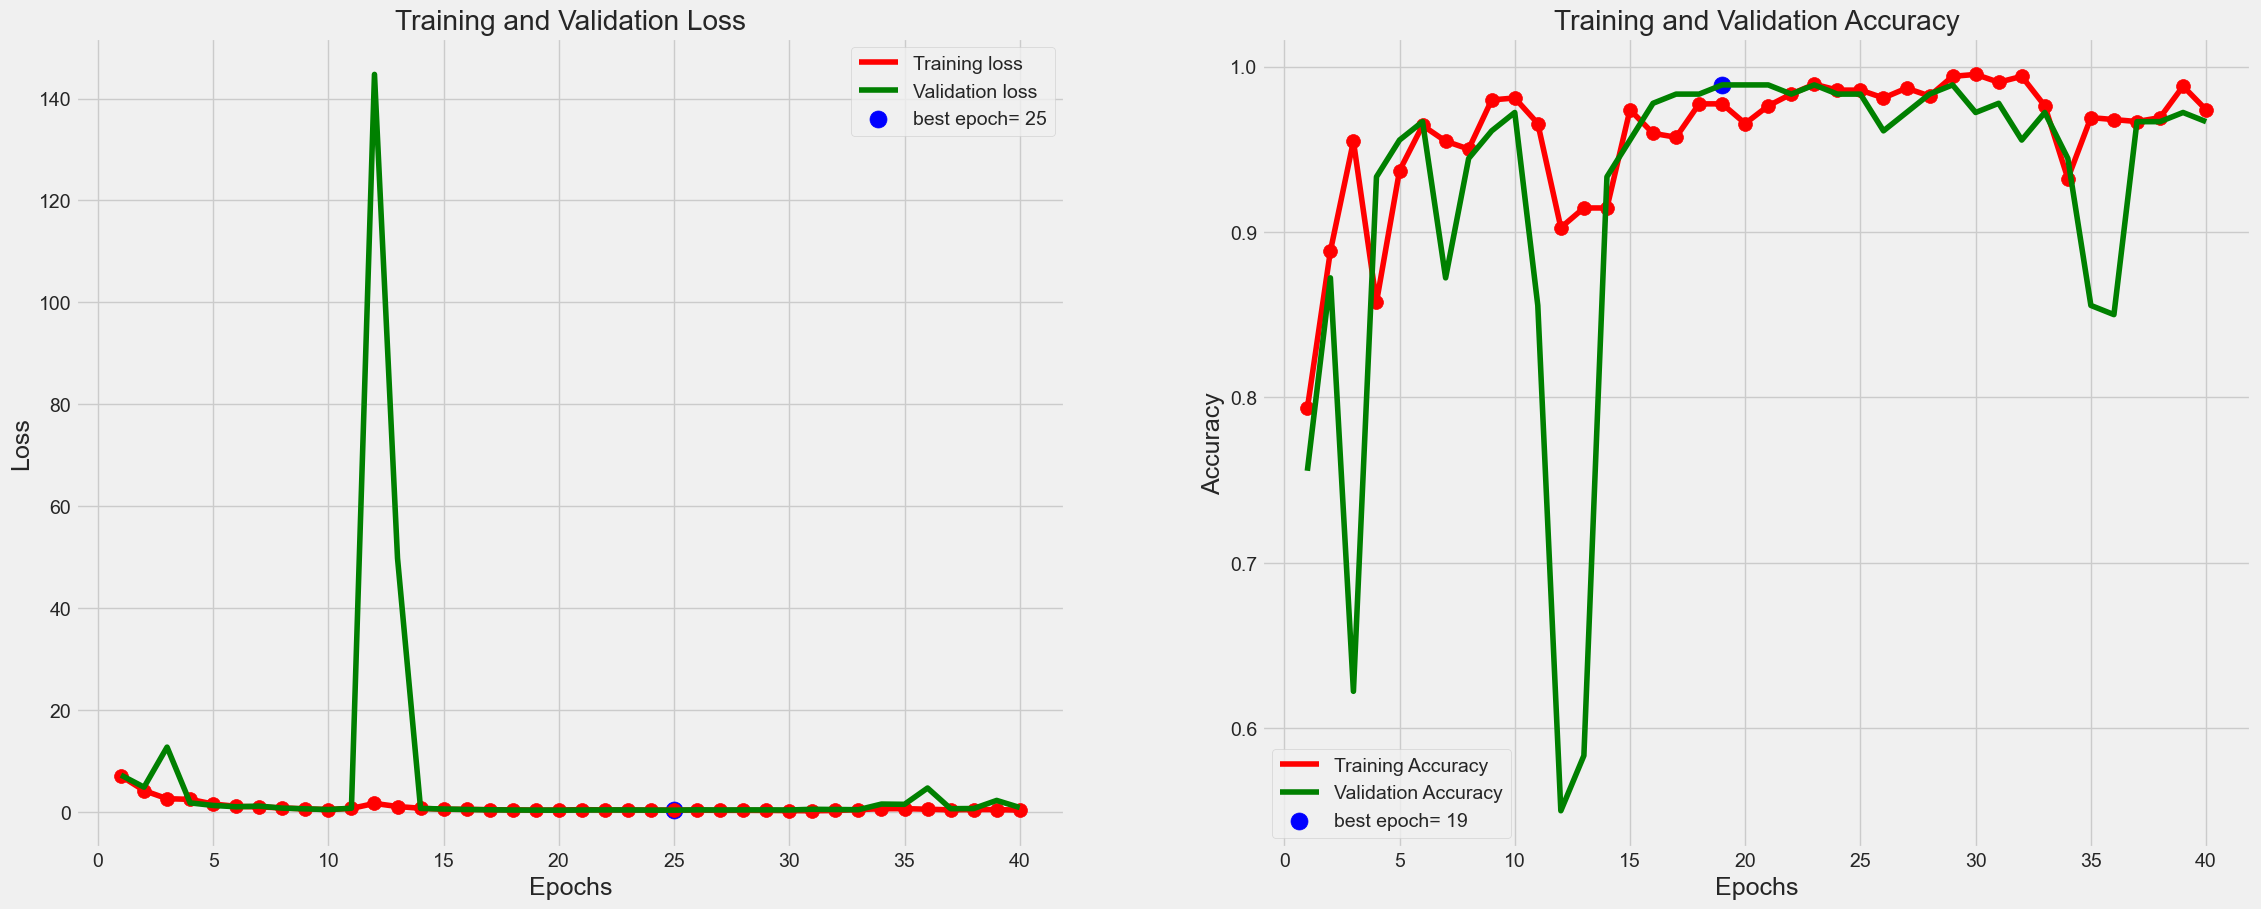

In [10]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss
    
loss_index=tr_plot(history,0)

<a> id="result"</a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

2023-03-13 13:03:07.375812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


181/181 [==============================] - 20s 49ms/step
there were 7 errors in 181 tests for an accuracy of  96.13 (0, 255, 255) (100, 100, 100)


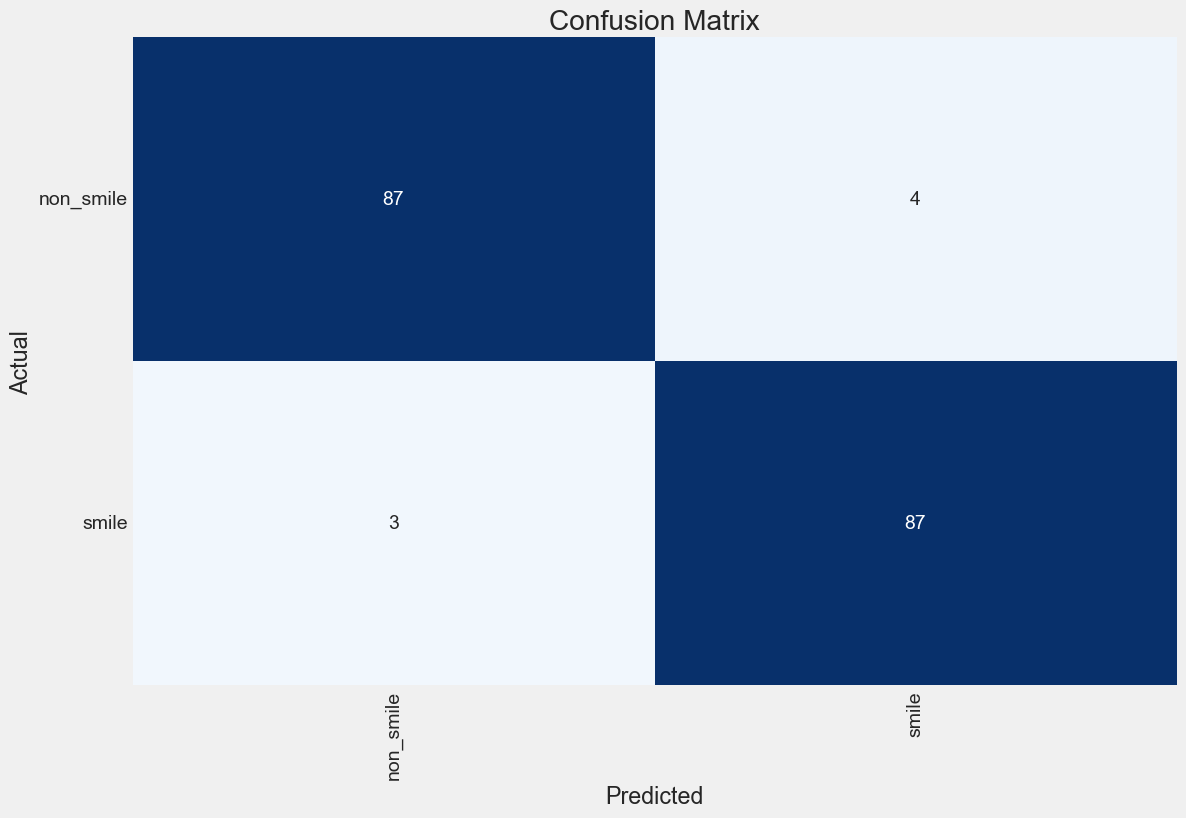

Classification Report:
----------------------
               precision    recall  f1-score   support

   non_smile     0.9667    0.9560    0.9613        91
       smile     0.9560    0.9667    0.9613        90

    accuracy                         0.9613       181
   macro avg     0.9614    0.9614    0.9613       181
weighted avg     0.9614    0.9613    0.9613       181



In [11]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):  
        file=test_gen.filenames[i]        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
            error_class=classes[pred_index]
            t=(file, error_class)
            error_list.append(t)            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print(msg, (0,255,255), (100,100,100))
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, f1score

errors, tests, error_list, f1score =predictor(test_gen)

In [17]:
if len(error_list) > 0 and len(error_list)<50:    
    print ('Below is a list of test files that were miss classified \n')
    print ('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))   
    sorted_list=sorted(error_list)
    for i in range(len(sorted_list)):
        fpath=sorted_list[i][0]
        split=fpath.split('/')          
        f=split[7]
        pred_class=sorted_list[i][1]
        print(f'{f:^30s}{pred_class:^30s}')
        

Below is a list of test files that were miss classified 

          Test File                    Predicted as         
     Amber_Frey_0001.jpg                  smile             
     Dave_Campo_0003.jpg                  smile             
   Estella_Warren_0001.jpg                smile             
  Federico_Fellini_0001.jpg               smile             
  King_Abdullah_II_0001.jpg             non_smile           
     Kurt_Warner_0005.jpg               non_smile           
  Natasha_McElhone_0002.jpg             non_smile           


<a id="save"></a>
# <center>Save the model

In [21]:
model.save('model.h5')

TypeError: Unable to serialize [2.0896919 2.1128855 2.108185 ] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

## input the test set from original dataset

In [23]:
test_dir=r'/Users/alfahwun/GMC/Transfert Learning/smiling or not/test'
bs=100
filepaths=[]
flist=sorted(os.listdir(test_dir))
for f in flist:
    fpath=os.path.join(test_dir,f)
    filepaths.append(fpath)
Fseries=pd.Series(filepaths, name='filepaths')
test_df=pd.concat([Fseries], axis=1)
gen=ImageDataGenerator()
test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=None, class_mode=None, target_size=img_size,
                                color_mode='rgb', shuffle=False, batch_size=bs)
preds=model.predict(test_gen, verbose=1)
pred_class=[]
files=[]
for i, p in enumerate(preds):
    index=np.argmax(p)
    pred_class.append( classes[index])
    file=test_gen.filenames[i].split('/')[7]
    files.append(file)
Fseries=pd.Series(files, name='File Name')
Cseries=pd.Series(pred_class, name='Predicted Class')
predictions_df=pd.concat([Fseries, Cseries], axis=1)
csv_path=os.path.join(working_dir, 'predictions.csv')
predictions_df.to_csv(csv_path, index=False)
# read in csv to make sure it is correct
df=pd.read_csv(csv_path)
print (df.head(20))

Found 12030 validated image filenames.
121/121 [==============================] - 53s 436ms/step
                          File Name Predicted Class
0                  AJ_Cook_0001.jpg           smile
1                 AJ_Lamas_0001.jpg           smile
2              Aaron_Guiel_0001.jpg           smile
3            Aaron_Peirsol_0001.jpg           smile
4            Aaron_Peirsol_0002.jpg           smile
5            Aaron_Peirsol_0003.jpg           smile
6            Aaron_Peirsol_0004.jpg       non_smile
7               Aaron_Pena_0001.jpg       non_smile
8             Aaron_Sorkin_0001.jpg           smile
9             Aaron_Sorkin_0002.jpg           smile
10            Aaron_Tippin_0001.jpg       non_smile
11               Abba_Eban_0001.jpg       non_smile
12        Abbas_Kiarostami_0001.jpg       non_smile
13     Abdel_Aziz_Al-Hakim_0001.jpg       non_smile
14      Abdel_Madi_Shabneh_0001.jpg       non_smile
15     Abdel_Nasser_Assidi_0001.jpg       non_smile
16          Abdoula